## VPP Plant Optimization Problem

#### Decision Variables
\begin{split} x_t &= \text{electricity (MW) sold (+) or consumed (-) by VPP during time period $t$} \\
g_t &= \text{binary; whether gas turbine is on/off during time period $t$} \\
\end{split}


#### Other Variables
$$\begin{aligned} T &= \text{number of hourly time periods $t$; 168 if weekly} \\
\lambda_t &= \text{forecasted price of electricity during time period $t$} \\
p_t &= \text{solar power generation from PV array during time period $t$} \\ 
w_t &= \text{wind power generation from wind turbine farm during time period $t$} \\ 
b_t &= \text{power flow into (+)/out of (-) battery system during time period $t$} \\
v_t &= \text{energy stored in battery system at the end of time period $t$} \\
\end{aligned}$$

#### Formulation
$$\begin{split} 
\text{maximize:} \quad &\sum_{t}^T \lambda_t x_t - C_g*g_t - S s_t \quad &\text{cost function}   \\
\text{subject to:} \quad &\forall \text{$t$:} &  \\
&     g_t - g_{t-1} \le s_t & \text{startup criteria} \\
&     b_t \le B_{max} & \text{max battery charge rate (MW)} \\
&     b_t \ge B_{min} & \text{max battery discharge rate (MW)} \\ 
&     v_t = v_{t-1} + b_{eff} b_t & \text{cumulative storage (MWh)} \\
&     v_t \le V_{max} & \text{max battery storage capacity (MWh)} \\
&     v_t \ge 0 & \text{min battery storage capacity (MWh)} \\
&     x_t = p_t + w_t + G g_t + b_t \qquad & \text{total electricity balance (MW)} \end{split}$$


\begin{split}&& s_{t} = \left\{\begin{array}{ll}1 & \mbox{if gas turbine is started up during time period $t$} \\
0  & \mbox{otherwise} \end{array} \right.\\  
&& g_t = \left\{\begin{array}{ll}  1  & \mbox{if gas turbine is run during time period $t$} \\
0  & \mbox{otherwise} \end{array} \right.\\\end{split}

#### Constants
$$\begin{split} T &= 168 &\text{number of hourly time periods $t$ in a week} \\
V_{max} &= 352 \text{ (MWh)} \quad &\text{battery capacity} \\
B_{min} &= 62 \text{ (MW)} &\text{max battery discharge rate} \\
B_{max} &= 62 \text{ (MW)} &\text{max battery charge rate} \\
b_{eff} &= 0.938 &\text{single trip battery efficiency} \\
G &= 52 \text{ (MW)} &\text{turbine power output} \\
S &= 190 \text{ (\$)} &\text{fixed turbine startup cost} \\
C_g &= 2600 \text{ (\$/hr)} &\text{cost of running gas turbine} \\
\end{split}$$


#### Gas Turbine Fuel Curve

In [27]:
from gurobipy import *
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import itertools as iter

### Define / Gather Data
#### a. Constants

In [28]:
T = 168
hours = [h for h in range(T)]
V_max = 352
B_max = 62
B_min = -62
G = 52
B_eff = 0.938
Cg = 2600 # 0.42 efficiency; assuming constant temperature
S = (1/6)*Cg # startup time, spindown time
season = 1  # 0 for january, 1 for July

# forecast error sigma for next 24h
p_err_sig_1d = 2
w_err_sig_1d = 4
l_err_sig_1d = 3

# forecast error sigma for 25-72h
p_err_sig_3d = 4
w_err_sig_3d = 8
l_err_sig_3d = 6

# forecast error sigma for 73-168h
p_err_sig_7d = 6
w_err_sig_7d = 12
l_err_sig_7d = 9


In [29]:
# Assume aeroderivative: LM6000
# Capital Cost:
# 50 MW * $930/kW capacity * 1000 kW/MW = $46.5M capital cost over life
# Cost spread across total hrs = 70,000 hrs
# Capital cost = $665/hr 
#
# Maintenance Cost:
# Delta: Engines cost $130 per flight-hr for 2 engined 737 (smaller)
# Assume $65 maintenance cost per hr of running LM6000 (larger but less extreme)
#
# Fuel Cost:
# LM2500 fuel consumption = 227 g/kW-hr at 37% efficiency
# LM6000 fuel consumption = 200 g/kW-hr at 42% efficiency
# Natural gas: $.000625/gram/2 * 200 = 0.125/kwH/2 = $3125
# $7.50/1000 ft^3
# 52.7 lbs natural gas/1000 ft^3
# $76/MwH
#$76/MwH * 50MwH = $3125
#
# Startup cost:
# 10 min operating cost
#
# Total cost = maintenance + fuel + capital = $65/hr + $3125/hr + $665/hr = $3800/hr

#### b. Solar PV Production

For each DNI, uses following formula to convert into MW:

MW = 0.161 (efficiency) *1.66815 (area in m^2) * 75000 (# of panels) * DNI (in W/m^2)

In [30]:
def solar_energy(solar_DNI):
    # given in MW
    energy = [0.161*1.66815*75000/1e6*DNI for DNI in solar_DNI]
    return energy

In [31]:
# Solar Output
solar_data = pd.read_csv('data/solar_data_2017.csv', header = 2)
solar_DNI = solar_data.loc[:,'DNI']
solar_DNI_jan = solar_DNI.loc[:T-1]   #first week of July solar data
solar_DNI_jul = solar_DNI.loc[4344:(4344+167)]  #first week of July solar data

if season == 0:
    p = solar_energy(solar_DNI_jan)
elif season == 1:
    p = solar_energy(solar_DNI_jul)

print("Total MWh produced from Solar PV is: ", sum(p))
print("Average MW from Solar PV is: ", sum(p)/len(p))

('Total MWh produced from Solar PV is: ', 1472.2252403512496)
('Average MW from Solar PV is: ', 8.763245478281247)


Text(0.5,1,'Solar Power Production')

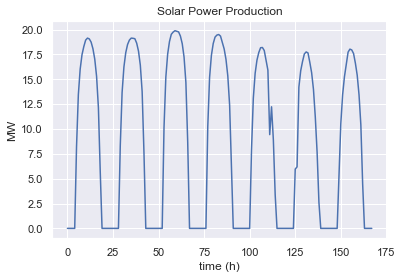

In [32]:
sns.set()
ax = sns.lineplot(hours,p)
ax.set(xlabel='time (h)', ylabel='MW')
plt.title('Solar Power Production')

#### c. Wind Production

In [35]:
# linear approximation for power curve of wind turbine energy generation

def wind_energy(windspeed):
    energy = [] #return in MW
    windspeed_65 = [i*np.log(65/.03)/np.log(10/.03)*2 for i in windspeed]
    for i in windspeed_65:
        if 3 <= i < 7:
            energy.append(41*(68*i-200)/1000)
        elif 7 <= i < 12:
            energy.append(41*(243*i-1427)/1000)
        elif 12 <= i < 24:
            energy.append(41*1500/1000)
        else:
            energy.append(0)
    return energy

In [36]:
# Wind output

weather_data = pd.read_csv('data/wind_data_2017.csv', header = 2)

windspeed_ms = weather_data.loc[:,'Wind Speed']
windspeed_ms_jan = windspeed_ms.loc[:T-1]   # first week of january wind data
windspeed_ms_jul = windspeed_ms.loc[4344:(4344+167)]   # first week of july wind data

if season == 0:
    w = wind_energy(windspeed_ms_jan) 
elif season == 1:
    w = wind_energy(windspeed_ms_jul)


Text(0.5,1,'Wind Power Production')

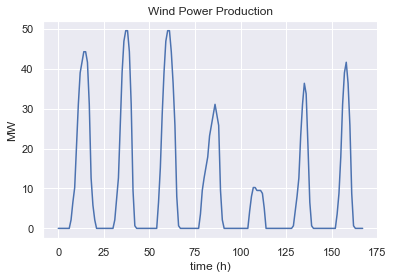

In [37]:
sns.set()
ax = sns.lineplot(hours,w)
ax.set(xlabel='time (h)', ylabel='MW')
plt.title('Wind Power Production')

#### e. Electricity Prices

In [32]:
# Electricity Price Forecast
if season == 0:
    prices = pd.read_csv('data/Hourly_Energy_Price_Jan_2017.csv')
    l = prices.iloc[7:,14]
    l=l.reset_index(drop=True)
    l.drop(columns=['index'])
elif season == 1:
    prices = pd.read_csv('data/Hourly_Energy_Price_Jul_2017.csv')
    l=prices.iloc[6:,14]
    l=l.reset_index(drop=True)

Text(0.5, 1.0, 'Electricity Price (LMP)')

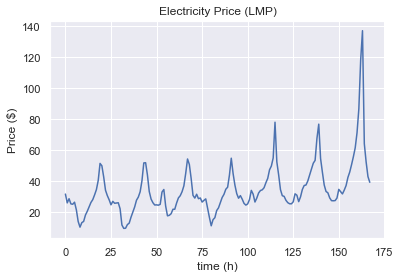

In [34]:
sns.set()
ax = sns.lineplot(hours, l)
ax.set(xlabel='time (h)', ylabel='Price ($)')
plt.title('Electricity Price (LMP)')

### Create Simulation Data -- 5 Scenarios Each

In [85]:

p_sig = [p_err_sig_1d]*24 + [p_err_sig_3d]*48 + [p_err_sig_7d]*96
w_sig = [w_err_sig_1d]*24 + [w_err_sig_3d]*48 + [w_err_sig_7d]*96
l_sig = [l_err_sig_1d]*24 + [l_err_sig_3d]*48 + [l_err_sig_7d]*96

np.random.seed(153)
nsims = 5
p_sim = pd.DataFrame({'hour': hours, 'solar_fcst': p})
w_sim = pd.DataFrame({'hour': hours, 'wind_fcst': w})
l_sim = pd.DataFrame({'hour': hours, 'elect_fcst': l})
for sim in range(nsims): 
    p_sim['sim_%d'%sim] = [max(np.random.normal(val, p_sig[idx], 1)[0].round(2),0) for idx,val in enumerate(p)]
    w_sim['sim_%d'%sim] = [max(np.random.normal(val, w_sig[idx], 1)[0].round(2),0) for idx,val in enumerate(w)]
    l_sim['sim_%d'%sim] = [np.random.normal(val, l_sig[idx], 1)[0].round(2) for idx,val in enumerate(l)]


Text(0.5, 1.0, 'Solar Power Scenarios')

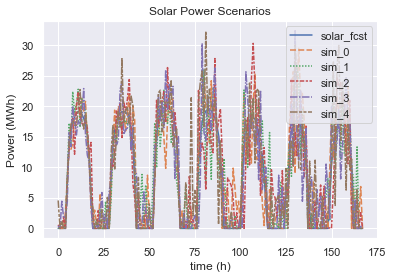

In [86]:
sns.set()
ax1 = sns.lineplot(data=p_sim.iloc[:,1:])
ax1.set(xlabel='time (h)', ylabel='Power (MWh)')
plt.title('Solar Power Scenarios')

Text(0.5, 1.0, 'Wind Power Scenarios')

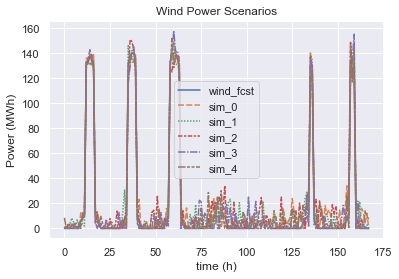

In [87]:
sns.set()
ax1 = sns.lineplot(data=w_sim.iloc[:,1:])
ax1.set(xlabel='time (h)', ylabel='Power (MWh)')
plt.title('Wind Power Scenarios')

Text(0.5, 1.0, 'Electricity Price Scenarios')

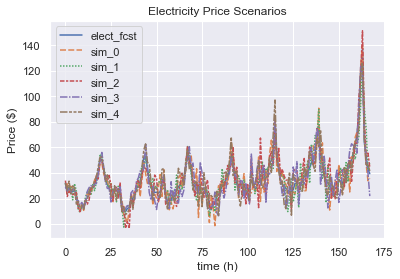

In [88]:
sns.set()
ax1 = sns.lineplot(data=l_sim.iloc[:,1:])
ax1.set(xlabel='time (h)', ylabel='Price ($)')
plt.title('Electricity Price Scenarios')

In [89]:
# construct all permutations of scenarios
# (p_sim, w_sim, l_sim)

sim_perm = list(iter.product(range(5),repeat=3))

### Optimization Model

In [101]:
def optimize_vpp_stochastic():

    model = Model("VPP")

    b,g,s,v = {},{},{},{}

    for t in range(T):
        b[t] = model.addVar(lb=B_min, ub=B_max, vtype="C", name="b(%s)"%(t))  # battery flow
        g[t] = model.addVar(vtype="B", name="g(%s)"%(t))  # gas turbine running?
        s[t] = model.addVar(vtype="B", name="s(%s)"%(t))  # gas turbine started?
        v[t] = model.addVar(lb=0, ub=V_max, vtype="C", name="m(%s)"%(t))  # battery storage
    model.update()

    # Set objective
    obj = LinExpr()

    for sim in sim_perm:
        p = p_sim['sim_%d'%sim[0]]
        w = w_sim['sim_%d'%sim[1]]
        l = l_sim['sim_%d'%sim[2]]
        obj += (1/len(sim_perm))*quicksum(l[t]*(b[t] + p[t] + w[t] + G*g[t]) - (Cg*g[t])\
                                - S*s[t] for t in range(T))

    model.setObjective(obj, GRB.MAXIMIZE)

    # Constraints
    for t in range(T):
        model.addConstr(b[t] <= B_max, "Max Batt Charge(%s)"%t)
        model.addConstr(b[t] >= B_min, "Max Batt Discharge(%s)"%t)
        model.addConstr(v[t] <= V_max, "Max Storage(%s)"%t)
        model.addConstr(v[t] >= 0, "Min Storage(%s)"%t)

    for t in range(1,T):
        model.addConstr(g[t] - g[t-1] <= s[t], "Startup Criteria(%s)"%t)
        model.addConstr(v[t] == (v[t-1] + B_eff*b[t]), "Batt Storage(%s)"%t)

    # set initial conditions for r[0] and v[0]
    model.addConstr(g[0] == 0, "Turbine Init Cond")
    model.addConstr(v[0] == 0.5*V_max, "Batt Storage Init Cond")
    model.update()

    ## write out to file
    # model.write('VPP_stochastic.lp')

    # Run
    model.Params.OutputFlag = 1 # 0 = silent mode
    model.optimize()
    
    return model


In [100]:
model.ObjVal

AttributeError: 'int' object has no attribute 'ObjVal'

In [92]:
g_sol, b_sol, s_sol, v_sol = [],[],[],[]
for t in range(T):
    b_sol.append(b[t].X)
    v_sol.append(v[t].X)
    g_sol.append(int(g[t].X))
    s_sol.append(int(s[t].X))

In [93]:
sol = pd.DataFrame(list(range(T)), columns=['hours'])
sol['batt_flow'] = b_sol
sol['batt_cap'] = v_sol
sol['gas_turb_on'] = g_sol
sol['gas_turb_start'] = s_sol
sol.head()

,hours,batt_flow,batt_cap,gas_turb_on,gas_turb_start
0,0,62.000000,176.000,0,0
1,1,62.000000,234.156,0,0
2,2,62.000000,292.312,0,0
3,3,62.000000,350.468,0,0
4,4,-60.366738,293.844,0,0


In [94]:
sol[sol['gas_turb_on'] == 1]

,hours,batt_flow,batt_cap,gas_turb_on,gas_turb_start
67,67,62.000000,177.532,1,1
68,68,62.000000,235.688,1,0
114,114,62.000000,177.532,1,1
115,115,62.000000,235.688,1,0
116,116,62.000000,293.844,1,0
134,134,62.000000,58.156,1,1
135,135,62.000000,116.312,1,0
136,136,62.000000,174.468,1,0
137,137,62.000000,232.624,1,0
138,138,62.000000,290.780,1,0


In [62]:
# profit without battery, for comparison

In [ ]:
# Andrew/Mike/Jason - webapp